http://blog.yhat.com/posts/customer-segmentation-using-python.html

<h1>Analiza profilu klienta</h1>

Firma prowadzi kampanie handlowe wysyłając do klientów oferty. 

ZADANIE: Pobieramy dane z pliku "datasets/WineKMC.xlsx". Co się w nich znajduje?

In [12]:
import pandas as pd
import numpy as np

df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


Czego dotyczą dane? 

Są to wystawione oferty sprzedaży win (pierwsza karta) oraz informacja o transakcjach dokonanych przez poszczególnych klientów (druga karta). 

  * Firma będzie tworzyć nowe oferty. 
  * Chcielibyśmy wiedzieć do których klientów skierować poszczególne oferty. 
  * Możemy założyć że klientów jest milion i nie jesteśmy w stanie rozpatrzyć każdego indywidualnie. 
  * Poza tym klient może chcieć kupić coś innego, dlatego nie możemy się kierować tylko tym co już kupił.

# Zad

Stwórzmy tabelę, gdzie w wierszach są klienci a w kolumnach oferty - dla każdego klienta zaznaczmy czy wybrał daną ofertę (1) czy nie (0).

In [7]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
# # save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]
# print(df)
# print("------------")
print(matrix)

offer_id customer_name    1    2    3    4    5    6    7    8    9 ...    23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
5               Barnes  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
6                 Bell  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
7              Bennett  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
8               Brooks  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
9                Brown  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
10              Butler  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
11            Campbell  0.0 

Podzielmy klientów na grupy (segmenty) - do jednej grupy włączamy podobnych klientów - podobni klienci reagują na podobne oferty. Użyjemy Kmeans do grupowania.

In [8]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5, random_state = 42)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])


ZADANIE: Jakie są liczności grup?

In [9]:
matrix.cluster.value_counts()

1    35
0    22
4    17
2    17
3     9
Name: cluster, dtype: int64

ZADANIE: Proszę zwizualizować wynik na płaszczyźnie (znacie odpowiednie metody)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


In [13]:
matrix.iloc[np.where(matrix['cluster'].values == 0)]['x']

1    -0.287539
4     0.088183
13   -0.579221
16   -0.406276
27   -0.412830
28   -0.339146
43   -0.504329
48   -0.596330
49   -0.382241
50   -0.168125
59   -0.064218
60   -0.202845
62   -0.110035
67   -0.118158
69   -0.187206
71   -0.266650
74   -0.202978
81   -1.274329
88    0.135104
90   -0.632199
92   -0.226293
98   -0.489805
Name: x, dtype: float64

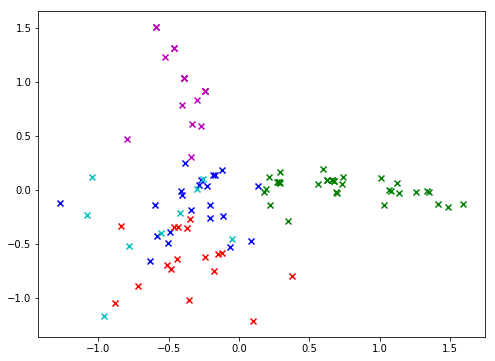

In [14]:
import matplotlib.pyplot as plt
import numpy as np



colors = ['b', 'g', 'r', 'c', 'm']

fig = plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(matrix.iloc[np.where(matrix['cluster'].values == i)[0]]['x'], matrix.iloc[np.where(matrix['cluster'].values == i)[0]]['y'],
            marker='x', color=colors[i], label='Iris-setosa')


# plt.plot(matrix['x'], matrix['y'], 'x', color = colors[matrix['cluster']])
plt.show()


Zanalizujmy ostatni klaster.

ZADANIE: Dla każdego wina wylistować ilość klientów które go kupili - z klastra 4 i z innych klastrów. 

In [15]:
df['is_4'] = matrix['cluster']==4
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Prosecco              26
       Espumante             22
       Champagne             11
       Malbec                 8
       Chardonnay             7
       Pinot Noir             7
       Cabernet Sauvignon     2
True   Prosecco               5
       Espumante              4
       Pinot Noir             3
       Cabernet Sauvignon     2
       Malbec                 2
       Champagne              1
Name: varietal, dtype: int64

Które wino jest kupowane tylko przez ten klaster, a które wcale?

ZADANIE: Spójrzmy na numeryczne atrybuty. Jak jest średnia ilości i rabatu?

In [16]:
df.groupby("is_4")[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,66.578313,48.277108
True,69.882353,44.588235


Czy ci klienci kupują duże czy małe ilości?

In [17]:
df.groupby("is_4")[['min_qty', 'discount']].std()

,min_qty,discount
is_4,,
False,56.925737,17.365731
True,56.997678,19.697902
